# Lab 3

## Objectives

* Master more array manipulation skills 
* Understand the SOM algorithm and its implementation
* Learn to manipulate image data using the PIL package
* Get familiar with Numpy / Sklearn / Matplotlab utilities

## A. Colour mapping using SOM

As usual, import some important stuff first:

In [2]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

We start with a toy task: randomly generate a color pixel population, display it as an image, and then use the SOM algorithm to organize a color map. 

In the following code, we form a pixel array of $64\times64=4096$ pixels, and use it to train a SOM map with a $16\times16$ grid. From a data quantization / compression perspective, we are to create a 256-entry codebook to represent a sample of the 24-bit colour space (well actually we only use 4096 colours as our raw data). 

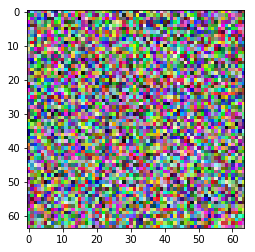

In [3]:
# first the random pixel array, and displaying it as an image
ar=np.random.randint(1,256, size=(64, 64,3))
pl.imshow(ar.astype("uint8"),interpolation='nearest')

Quite messy, isn't it? Our intention is to employ an 2D SOM, so its topology preserving capability will draw similar colors (in the 3-D RGB space) into neighbourhood on a 2D grid.

In [4]:
# reshape it into a long array colour pixels (each as a 3-D RGB vectors) - this is the input data to be clustered
data=ar.reshape(64*64,3)

In [5]:
# Take a look of the array. Each line represents the R G B value of a pixel.
data

array([[ 78,  20, 121],
       [116, 223, 255],
       [116, 111, 240],
       ..., 
       [ 83, 233,  47],
       [153, 148, 135],
       [224, 184, 194]])

Next, we get ready for a SOM and carry out random initialization of the weight vectors. We randomly assign data vectors to initial weights. Note that Python's array assignment is in fact referencing, so to avoid changing the original data while changing the weights (later), we need to employ the copy() function. 

In [6]:
# randomly init SOM weight vectors by copying random input vectors
mapsize=16
ninput=data.shape[0]
w=data[np.random.randint(ninput)].copy() 
# randomly picks more data vectors, and vertically stack them under
for i in range(mapsize*mapsize-1):
    w=np.vstack((w,data[np.random.randint(ninput)].copy()))

Now, the the weight array remains 1-D (with index 0..16$\times$16-1), we need to arrange them onto to a $16\times16$ grid so as to do SOM:

In [7]:
# reshape weight vectors so they map onto a 16x16 grid (now they are referred to as "nodes"). Check on the shape. 
nodes=w.reshape(mapsize,mapsize,-1).astype(float)
nodes.shape

(16, 16, 3)

We define two functions for SOM learning. The algorithm is simplified. 

In [8]:
# Define two functions of the SOM algorithm
def findBMU(x,nodes):
    bmu=np.argmin(np.linalg.norm(nodes-x,axis=2))
    return bmu/mapsize, bmu%mapsize

def updateNodes(x, nodes, i, j, nei, gamma):
    for m in range(-nei,nei+1):
        for n in range(-nei,nei+1):
            if (i+m)<0 or (i+m)>=mapsize: continue
            if (j+n)<0 or (j+n)>=mapsize: continue
            # update the node, and the neighbourhood, defined by a bubble function
            nodes[i+m,j+n]+=gamma*(x-nodes[i+m,j+n])

Now let the learning begin - the main code follows. Feel free to tune the parameter settings for possible improvement. 

In [9]:
# Now the main program - train the map
"""
niters=6000  # number of total iterations
neigh=4      # initial neighbour radius
gamma=0.05   # initial learning rate
"""

niters=60000  # number of total iterations
neigh=10    # initial neighbour radius
gamma=0.5   # initial learning rate

for t in range(niters):
    # randomly pick a row from the "data" array for online training
    x=data[np.random.randint(data.shape[0])]
    i,j=findBMU(x,nodes)
    updateNodes(x,nodes,i,j,neigh*(niters-t)/niters, gamma*(niters-t)/niters)
    
print ("done")

done


**Task A1**. 
Question: Explain the SOM implementation given above. 
    - What neighbourhood function is used?
    - How are the neighbourhood size and the learning rate adapted over time?



Type in your answer below -

Explaination:

A bubble function is used as the neighbourhood function. 

The neighbourhood size and the learning rate both decreases over time as the number of iterations increase, stabilizing the result. 



**Task A2**. Display the learning outcome. 

Note the SOM weights are now a float array. Convert it into the 'uint8' type (8-bit unsigned integer) (so that matplotlib can render it properly). Then use the "pl.imshow()" function. 

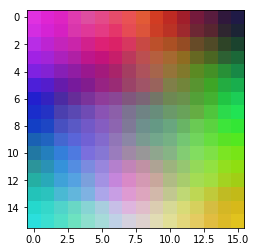

In [14]:
# Your code display the learned color map


pl.imshow(nodes.astype("uint8"),interpolation='nearest')



If everything works well, we'll see an ordered color map displayed above. 

Now, let's take a look of the numerical quality of the learned map - how well does it quantize the original pixels?

**Task A3.** Write a function to return the overall average quantization of a codebook, given the data array, and the nodes array of a SOM. Test it on the color map. 

quantization erro:  27.0651218903


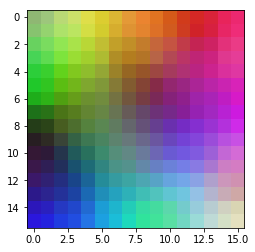

In [15]:
# your code for Task A3.

# Function calculating quantization error.      
def quant_error(dataIn, codebook):
    total_difference = [] 
    for pixel in dataIn:
        i,j=findBMU(pixel,nodes)
        
        code_book_entry = nodes[i][j]
        error = np.linalg.norm(code_book_entry-pixel)
        #print ("Pixel:", pixel, " codebook entry: ", code_book_entry, "error: ", error)
        total_difference.append(error)
    
    total_error = sum(total_difference)
    return total_error / len(dataIn) 



# Test function
def test_SOM(niters,neigh,gamma):
    for t in range(niters):
        # randomly pick a row from the "data" array for online training
        x=data[np.random.randint(data.shape[0])]
        i,j=findBMU(x,nodes)
        updateNodes(x,nodes,i,j,neigh*(niters-t)/niters, gamma*(niters-t)/niters)
    pl.imshow(nodes.astype("uint8"),interpolation='nearest')    
    print "quantization erro: ", quant_error(data,nodes)

    
#tesing code here

niters=6000  # number of total iterations
neigh=10    # initial neighbour radius
gamma=0.5   # initial learning rate

test_SOM(niters=niters,neigh=neigh,gamma=gamma)
        
    
   

    


** Task A4. ** Try tuning the parameter scheme in the SOM code, and observe the effect on the generated colour map, as well as the quantization error. Report your findings. 




Observations:

1. Smaller neighbourhood leads to smaller quantization error (as the clusters get smaller, values are less spread). However, it also leads to a loss of clustering effect when the value gets too small.


2. Larger neighbourhood leads to better generalization of the input, while smaller neighbourhood gives less information about the correlation between the datapoints, in exchange for lower quantization error? 

3. Larger neighbourhood with high number of iteration and high initial gamma value leads to smoother quantization, and low quantization error.（I used the configuration of neigh=10,gamma=0.5,iter=600000, which result in quantization error of 17.8) This is more computationally expensive, however. 


...

## B. Image segmentation

For the 2nd part of the lab we will play with image segmentation as a practial application of clustering. The purpose of image segmentation is to extract homogeneous "regions" for further classification or shape analysis. Hence it is intended that each pixel is used as a data point.

The large size of the dataset (with 500x300 rows of 3-D vectors) will cause some memory issue to the silhouette coefficient implementatoin in Sklearn, but this is overcome by using sampling as we'll see.

We employ the PIL package to read in an image. The "pix" array contains a RGB color vector for each pixel:

In [17]:
# Read the image into a pix array
from PIL import Image
img=Image.open("africa.jpg")
pix=np.array(img)[:,:,0:3]
pl.imshow(pix)

IOError: [Errno 2] No such file or directory: 'africa.jpg'

How many "clusters" should we try on this image? This depends on the visual or semantic granularity we use to assess the image. Let's run k-means with a range of cluster numbers and let the Silhouette Coefficients have a say on the quality of clustering. Please refer to Sklearn's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html">k-means page</a> for more information. 

In [ ]:
from sklearn.cluster import KMeans    
from sklearn import metrics

In [ ]:
# reshape the pix array for clustering
pix=pix.reshape((-1,3)).astype(float)
print 'Plain k-means - k : silh. score'
# loops through a few k's - takes a while to finish
for k in range(2,10):
    kmeans = KMeans(init='random', n_clusters=k, copy_x=False, n_init=10).fit(pix)
    labels=kmeans.labels_
    print k,':', metrics.silhouette_score(pix, labels, sample_size=3000, metric='euclidean')

**Task B1**. How does the coefficients change when the number of clusters ($k$) increases? What do you think should be the best $k$?

Initially, as the number of clusters (k) increases, the Silhouette Coefficient increases with it. This continues until the score peaks at around 5 clusters, then it declines. 

5 should be the best k value. 

- 

** Task B2**. Repeat the same process for k-means using k-means++ initialization. Report your findings.

In [ ]:
# your code ...

# loops through a few k's - takes a while to finish
for k in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters=k, copy_x=False, n_init=10).fit(pix)
    labels=kmeans.labels_
    print k,':', metrics.silhouette_score(pix, labels, sample_size=3000, metric='euclidean')

*Your comments* --

I found that there is no significant difference between the s.score of k-means using k-means++ compared to that of random initialization. In some cases, random initialization performcne marginally better. 


- 

Now, pick a $k$ and conduct k-means clustering for multiple times to compare the initialization effects. We try with random initialization first, generating a boxplot of the silhouette coefficients. (This may take a while to run.)

In [ ]:
# try a few k values and see the silhouette score ranges
tt=10 # try 10 runs for each k
k=5
sscores=np.zeros((tt))


for t in range(tt):
    kmeans = KMeans(init='random', n_clusters=k, copy_x=False, n_init=1).fit(pix)
    labels=kmeans.labels_
    sscores[t]=metrics.silhouette_score(pix, labels, sample_size=3000, metric='euclidean')
    print t, sscores[t]

pl.boxplot(sscores)
pl.xlabel('k')
pl.ylabel('Silhouette coeff.')
pl.title('Random init.')

**Task B3**. Do the same using k-means++. 

In [ ]:
# your code ...


tt=10 # try 10 runs for each k
k=5
sscores=np.zeros((tt))
for t in range(tt):
    kmeans = KMeans(init='k-means++', n_clusters=k, copy_x=False, n_init=1).fit(pix)
    labels=kmeans.labels_
    sscores[t]=metrics.silhouette_score(pix, labels, sample_size=3000, metric='euclidean')
    print t, sscores[t]

pl.boxplot(sscores)
pl.xlabel('k')
pl.ylabel('Silhouette coeff.')
pl.title('k-means++.')

**Compare** the s.c. boxplots.

Your comments:




S.score of random init for the same k value has a wider spread. K-means++ generates some outliers, but in general the results has a smaller spread. The median value fro K-means++ is also slightly higher than random initialization. 





- <font color="red">**JD**: Better to show these two boxplots side by side. </font>

## Extra

We may wonder what the "segmented" image looks like. Complete the following code, so that the pixel values are replaced by the corresponding cluster centres' colour and displayed. 

In [13]:
# visualization of segmentation result - assign cluster centre colours back to pixels
kmeans = KMeans(init='random', n_clusters=6).fit(pix)
labels=kmeans.labels_

# create a pix2 with pixel colours replaced by prototypes (cluster centres)


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels
    source: http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html"""
    
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]].astype(uint8)
            label_idx += 1
    return image



pix2=recreate_image(kmeans.cluster_centers_,labels,300,500)
#pl.imshow(pix2.reshape((300,500,3)))
pl.imshow(pix2)

NameError: name 'KMeans' is not defined

End of Lab 3. 

<p><font color="red">**JD**: Colors are not quite right - cluster centres are of real values and need to be cast into unsigned integer. 

<p>Well done! 
Mark: **95%**</font>